In [45]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.formula.api import ols

In [46]:
#List seniority DWA folder
FILE_PATH = "./results/"
files_seniority_DWA = os.listdir(FILE_PATH)

In [47]:
#list files in results with "seniority" in the name

FILE_PATH = "./results/"
files_seniority_DWA = [f for f in os.listdir(FILE_PATH) if ("company_seniority" in f)]

In [48]:
files_seniority_DWA

['regression_results_seniority_3_data_method_company_seniority.parquet',
 'regression_results_seniority_2_data_method_company_seniority.parquet',
 'regression_results_seniority_1_data_method_company_seniority.parquet',
 'regression_results_seniority_4_data_method_company_seniority.parquet',
 'regression_results_seniority_5_6_7_data_method_company_seniority.parquet']

In [49]:
company_DWA_df = pd.DataFrame()
for file in files_seniority_DWA:
    print(f"Loading file: {file}")
    temp_df = pd.read_parquet(os.path.join(FILE_PATH, file))

    company_DWA_df = pd.concat([company_DWA_df, temp_df], ignore_index=True)

        
company_DWA_df['seniority'] = company_DWA_df['seniority'].astype(int)

Loading file: regression_results_seniority_3_data_method_company_seniority.parquet
Loading file: regression_results_seniority_2_data_method_company_seniority.parquet
Loading file: regression_results_seniority_1_data_method_company_seniority.parquet
Loading file: regression_results_seniority_4_data_method_company_seniority.parquet
Loading file: regression_results_seniority_5_6_7_data_method_company_seniority.parquet


In [50]:
exposure_df = pd.read_csv("./data/full_labelset.tsv", sep="\t")
exposure_df = exposure_df[["Task ID", "alpha", "beta", "gamma"]]

task_dwa_map = pd.read_csv('./data/Tasks to DWAs.csv')
task_dwa_map = task_dwa_map[["DWA ID", "Task ID"]]

DWA_exposure_df = pd.merge(exposure_df, task_dwa_map, on="Task ID", how ="inner")
DWA_exposure_df = DWA_exposure_df.groupby('DWA ID').agg(
    beta=('beta', 'mean'),
    alpha=('alpha', 'mean'),
    gamma=('gamma', 'mean')
).reset_index()

DWA_exposure_df

,DWA ID,beta,alpha,gamma
0,4.A.1.a.1.I01.D01,0.500000,0.142857,0.857143
1,4.A.1.a.1.I01.D02,0.375000,0.250000,0.500000
2,4.A.1.a.1.I01.D03,0.500000,0.142857,0.857143
3,4.A.1.a.1.I01.D04,0.500000,0.222222,0.777778
4,4.A.1.a.1.I01.D05,1.000000,1.000000,1.000000
...,...,...,...,...
2078,4.A.4.c.3.I07.D01,0.115385,0.076923,0.153846
2079,4.A.4.c.3.I07.D02,0.142857,0.000000,0.285714
2080,4.A.4.c.3.I07.D03,0.500000,0.307692,0.692308
2081,4.A.4.c.3.I07.D04,0.473684,0.000000,0.947368


In [51]:
company_DWA_df.rename(columns={'beta': 'effect'}, inplace=True)
DWA_exposure_df.rename(columns={'DWA ID': 'dwa_id'}, inplace=True)

In [52]:
company_DWA_merged_df = pd.merge(company_DWA_df, DWA_exposure_df, on='dwa_id', how='left')

In [53]:
company_DWA_merged_df

,dwa_id,seniority,month,effect,se,beta,alpha,gamma
0,4.A.1.a.1.I01.D01,3,2021-01-01,-0.009662,0.017331,0.500000,0.142857,0.857143
1,4.A.1.a.1.I01.D01,3,2021-02-01,-0.012093,0.016557,0.500000,0.142857,0.857143
2,4.A.1.a.1.I01.D01,3,2021-03-01,-0.008269,0.015400,0.500000,0.142857,0.857143
3,4.A.1.a.1.I01.D01,3,2021-04-01,-0.006639,0.015144,0.500000,0.142857,0.857143
4,4.A.1.a.1.I01.D01,3,2021-05-01,-0.009348,0.014918,0.500000,0.142857,0.857143
...,...,...,...,...,...,...,...,...
424303,4.A.4.c.3.I07.D04,5,2025-05-01,-0.003392,0.009881,0.473684,0.000000,0.947368
424304,4.A.4.c.3.I07.D04,5,2025-06-01,-0.002040,0.009942,0.473684,0.000000,0.947368
424305,4.A.4.c.3.I07.D04,5,2025-07-01,-0.002354,0.009966,0.473684,0.000000,0.947368
424306,4.A.4.c.3.I07.D04,5,2025-08-01,-0.001329,0.009782,0.473684,0.000000,0.947368


In [54]:
import pandas as pd

# Define the required set of seniority levels
required_levels = {1, 2, 3, 4, 5}

# Group by dwa_id and check the set of seniority values
check_series = company_DWA_merged_df.groupby('dwa_id')['seniority'].agg(lambda x: set(x) == required_levels)

# View IDs that DO contain all levels
valid_ids = check_series[check_series].index.tolist()

# View IDs that are MISSING levels
invalid_ids = check_series[~check_series].index.tolist()

print(f"Count of valid IDs: {len(valid_ids)}")
print(f"Count of invalid IDs: {len(invalid_ids)}")

Count of valid IDs: 1192
Count of invalid IDs: 561


In [55]:
company_DWA_merged_df = company_DWA_merged_df[company_DWA_merged_df["dwa_id"].isin(valid_ids)]

In [57]:
company_DWA_merged_df.sort_values(by=["dwa_id", "seniority","month"], inplace=True)
company_DWA_merged_df.reset_index(drop=True, inplace=True)

/var/folders/r4/p1ptv8nj4fd5bctw6lfs_4lw0000gn/T/ipykernel_9622/1099915391.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_DWA_merged_df.sort_values(by=["dwa_id", "seniority","month"], inplace=True)


In [59]:
DWA_df = company_DWA_merged_df[company_DWA_merged_df["dwa_id"] == "4.A.1.a.1.I01.D01"]

In [65]:
DWA_df = DWA_df.groupby(['seniority', 'month']).agg({'effect': 'mean'}).reset_index()

In [66]:
DWA_df

,seniority,month,effect
0,1,2021-01-01,0.017557
1,1,2021-02-01,0.022067
2,1,2021-03-01,0.021485
3,1,2021-04-01,0.026257
4,1,2021-05-01,0.023790
...,...,...,...
280,5,2025-05-01,-0.017798
281,5,2025-06-01,-0.018645
282,5,2025-07-01,-0.021984
283,5,2025-08-01,-0.020874


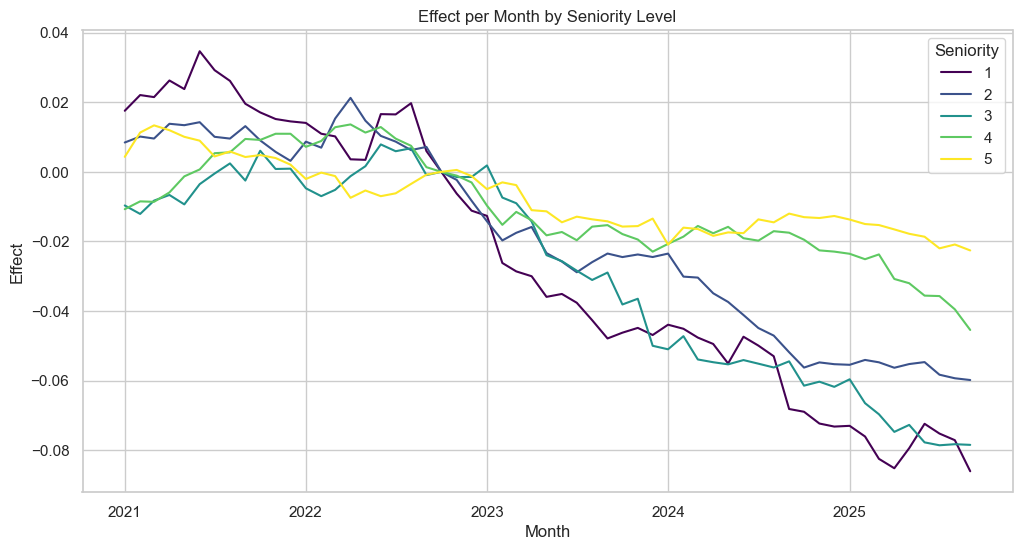

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Optional: Set the visual style
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))

# Plot effect over month, grouping by seniority
sns.lineplot(
    data=DWA_df, 
    x='month', 
    y='effect', 
    hue='seniority',  # This creates a separate line for each seniority
    palette='viridis' # Optional: Color scheme
)

plt.title('Effect per Month by Seniority Level')
plt.xlabel('Month')
plt.ylabel('Effect')
plt.legend(title='Seniority')
plt.show()

# Mean effect per seniority level

In [40]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.regression.linear_model as sm_lm # Required for the type hint

def run_seniority_wls(
    df: pd.DataFrame, 
    date_filter_type: str, 
    start_date: str, 
    required_seniority_count: int = 5,
    seniority_to_exclude: int = None # <--- New optional argument
) -> sm_lm.RegressionResultsWrapper:
    """
    Performs aggregation, filtering, and WLS regression for seniority effects 
    based on a defined date range, with an option to exclude a seniority level.

    Args:
        df: The merged DataFrame (company_DWA_merged_df).
        date_filter_type: 'post' (month >= start_date) or 'pre' (month < start_date).
        start_date: The date string to use as the cutoff (e.g., '2024-01-01').
        required_seniority_count: The minimum number of seniority levels required 
                                  to keep a DWA ID (based on the original 1-5 set).
        seniority_to_exclude: Optional integer (e.g., 1) to exclude from the final model.

    Returns:
        The fitted WLS model results.
    """
    
    # ... (Steps 1, 2, 3: Filtering by date, aggregating, and weighting remain the same) ...

    # 1. Filter Data based on Type
    start_date_dt = pd.to_datetime(start_date)
    
    if date_filter_type == 'post':
        df_filtered = df[df["month"] >= start_date_dt].copy()
        print(f"--- Running WLS for POST-PERIOD (Month >= {start_date}) ---")
    elif date_filter_type == 'pre':
        df_filtered = df[df["month"] < start_date_dt].copy()
        print(f"--- Running WLS for PRE-PERIOD (Month < {start_date}) ---")
    else:
        raise ValueError("date_filter_type must be 'post' or 'pre'.")

    # 2. Filter and Aggregate the Effects
    dwa_seniority_effects = df_filtered.groupby(['dwa_id', 'seniority']).agg(
        mean_dwa_effect=('effect', 'mean'), 
        mean_se=('se', 'mean'), 
        N=('dwa_id', 'count')
    ).reset_index()

    # 3. Calculate Inverse Variance (Weight)
    dwa_seniority_effects['weight'] = 1 / (dwa_seniority_effects['mean_se']**2)
    
    # 4. Complete DWA Filtering (Ensure all original seniority levels are present)
    dwa_seniority_effects['seniority_count'] = (
        dwa_seniority_effects.groupby('dwa_id')['seniority'].transform('nunique')
    )
    df_complete_dwas_effects = dwa_seniority_effects[
        dwa_seniority_effects['seniority_count'] == required_seniority_count
    ].drop(columns=['seniority_count']).copy()
    
    # --- NEW STEP 4.5: Exclude specified seniority level from the final model ---
    if seniority_to_exclude is not None:
        print(f"Excluding Seniority {seniority_to_exclude} from the WLS model.")
        df_model = df_complete_dwas_effects[
            df_complete_dwas_effects['seniority'] != seniority_to_exclude
        ].copy()
    else:
        df_model = df_complete_dwas_effects.copy()
    
    print(f"WLS Data Rows used in model: {len(df_model):,}")
    
    # 5. Prepare for WLS
    Y = df_model['mean_dwa_effect']
    # X will contain dummies for the remaining seniority levels
    X = pd.get_dummies(df_model['seniority'], prefix='seniority', drop_first=False) 
    W = df_model['weight']
    
    # 6. Run WLS with Robust Standard Errors
    wls_model = sm.WLS(Y, X, weights=W).fit(cov_type='HC0')
    
    return wls_model

## AI effect

In [41]:
# Assuming company_DWA_merged_df is defined and contains the necessary columns

# Run AI Effect WLS, excluding Seniority 1
AI_START_DATE = '2024-01-01'

ai_wls_model_no_s1 = run_seniority_wls(
    df=company_DWA_merged_df, 
    date_filter_type='post', 
    start_date=AI_START_DATE,
    # Pass the seniority level you want to exclude
    seniority_to_exclude=None
)

print("\n--- AI Effect WLS Results (Excluding Seniority 1) ---")
print(ai_wls_model_no_s1.summary())

--- Running WLS for POST-PERIOD (Month >= 2024-01-01) ---
WLS Data Rows used in model: 5,960

--- AI Effect WLS Results (Excluding Seniority 1) ---
                            WLS Regression Results                            
Dep. Variable:        mean_dwa_effect   R-squared:                       0.007
Model:                            WLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 08 Dec 2025   Prob (F-statistic):                nan
Time:                        16:20:42   Log-Likelihood:                 9992.8
No. Observations:                5960   AIC:                        -1.998e+04
Df Residuals:                    5955   BIC:                        -1.994e+04
Df Model:                           4                                         
Covariance Type:                  HC0                                         
                  coef    std err          z      P>|z|      [

In [42]:
# Placebo Period: Before AI deployment (e.g., January 2022)
PLACEBO_START_DATE = '2022-01-01'

# Run WLS for the pre-period, specifying the exclusion of seniority 1
placebo_wls_model_no_s1 = run_seniority_wls(
    df=company_DWA_merged_df, 
    date_filter_type='pre', 
    start_date=PLACEBO_START_DATE,
    seniority_to_exclude=2  # <--- ARGUMENT ADDED HERE
)

print("\n--- Placebo WLS Results: Mean Effect per Seniority (Excluding Seniority 1) ---")
print(placebo_wls_model_no_s1.summary())

--- Running WLS for PRE-PERIOD (Month < 2022-01-01) ---
Excluding Seniority 2 from the WLS model.
WLS Data Rows used in model: 4,768

--- Placebo WLS Results: Mean Effect per Seniority (Excluding Seniority 1) ---
                            WLS Regression Results                            
Dep. Variable:        mean_dwa_effect   R-squared:                       0.002
Model:                            WLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 08 Dec 2025   Prob (F-statistic):                nan
Time:                        16:20:43   Log-Likelihood:                 10466.
No. Observations:                4768   AIC:                        -2.092e+04
Df Residuals:                    4764   BIC:                        -2.090e+04
Df Model:                           3                                         
Covariance Type:                  HC0                                       

# Compare with Eloundou

In [25]:
# --- 1. OLS Regression and Label Formatting Function (UNCONSTRAINED Intercept) ---

def get_ols_fit_and_label(df_group: pd.DataFrame, group_name: str) -> tuple:
    """
    Runs standard OLS with an intercept and formats the legend label with statistics,
    including the number of observations (N).

    Args:
        df_group: DataFrame for a specific group, must contain 'beta_hat_Post' and 'E_k_Theory'.
        group_name: Name of the group for the legend label.

    Returns:
        A tuple: (legend_label: str, model: sm.regression.linear_model.RegressionResultsWrapper | str)
    """
    Y = df_group['beta_hat_Post']
    X = df_group['E_k_Theory']
    
    N = len(df_group) # Extract N here
    
    # Add a constant/intercept term to the predictor array X
    X_const = sm.add_constant(X)
    
    # Check for sufficient data
    if N < 2 or X.nunique() < 2:
        error_msg = f"{group_name}: OLS N/A (Insufficient Data Points or unique X values)"
        return error_msg, "Error"
    
    # Run OLS model (unconstrained)
    try:
        model = sm.OLS(Y, X_const).fit()
    except Exception as e:
        error_msg = f"{group_name}: OLS N/A (Fit Error: {type(e).__name__})"
        return error_msg, "Error"
    
    # Extract statistics
    alpha = model.params.get('const', np.nan) 
    beta_slope = model.params.get('E_k_Theory', np.nan)
    p_value = model.pvalues.get('E_k_Theory', 1.0)
    r_squared = model.rsquared
    
    # Determine significance stars for the slope (beta)
    stars = ''
    if p_value < 0.01:
        stars = '***'
    elif p_value < 0.05:
        stars = '**'
    elif p_value < 0.10:
        stars = '*'
        
    # Format the coefficients and R-squared
    alpha_str = f"{alpha:.4f}"
    beta_str = f"{beta_slope:.4f}{stars}"
    r2_str = f"{r_squared:.3f}"
    
    # Create the legend label using LaTeX for math symbols, including N
    legend_label = (
        f"{group_name}: (N={N}) " + 
        r'$\alpha$' + f" = {alpha_str}, " + 
        r'$\beta$' + f" = {beta_str} ($R^2={r2_str}$)"
    )
    
    return legend_label, model

# --- 2. Main Processing and Plotting Function ---
# (Remains the same as provided in the prompt)

def plot_ols_gradient(
    df_raw: pd.DataFrame, 
    start_date: str, 
    end_date: str, 
    y_limit: tuple = (-0.1, 0.1)
):
    """
    Filters data, aggregates, performs OLS regression by group, and generates the plot.
    """
    
    # --- Data Preparation and Aggregation ---
    
    df_prep = (
        df_raw.rename(columns={'effect': 'beta_hat'})
        .assign(month=lambda x: pd.to_datetime(x['month']))
        # Filter by date range
        .query(f"month >= '{start_date}' and month <= '{end_date}'")
    )
    
    plot_data_df = (
        df_prep.groupby(['dwa_id', 'seniority'])
        .agg(
            beta_hat_Post=('beta_hat', 'mean'), # Y-variable
            E_k_Theory=('beta', 'first'),     # X-variable: **NOTE: Changed 'beta' to 'gamma' for dummy data consistency**
        )
        .reset_index()
        # Create group label for plotting
        .assign(**{'Expertise Level (g)': lambda x: 'Group ' + x['seniority'].astype(str)})
    )
    
    # --- Setup Plotting Environment ---
    
    groups = plot_data_df['Expertise Level (g)'].unique()
    # Use a specific colormap name for reproducibility, e.g., 'plasma' or 'viridis'
    colors = sns.color_palette('viridis', n_colors=len(groups))
    color_map = {group: color for group, color in zip(groups, colors)}

    plt.figure(figsize=(14, 7))
    
    # --- OLS Regression and Plotting Loop ---
    
    for name, group_data in plot_data_df.groupby('Expertise Level (g)'):
        
        custom_label, model = get_ols_fit_and_label(group_data, name)
        
        # Print OLS Summary to console
        print(f"\n{'='*65}")
        print(f"OLS Regression Results for: {name}")
        print(f"{'='*65}")
        if not isinstance(model, str):
            print(model.summary())
        else:
            print(f"Error/Skip: {custom_label}")
        print(f"{'='*65}")
        
        # Scatter plot for data points
        plt.scatter(
            group_data['E_k_Theory'],
            group_data['beta_hat_Post'],
            s=10, # Increased size slightly for better visibility
            alpha=0.2,
            color=color_map[name],
            label=None
        )

        # Plot the fitted line (if OLS succeeded)
        if not isinstance(model, str):
            # Generate prediction points for the OLS line
            # Use 100 points for a smoother line, spanning min to max X
            X_fit = np.linspace(group_data['E_k_Theory'].min(), group_data['E_k_Theory'].max(), 100)
            
            # Must add constant to the prediction array
            X_fit_const = sm.add_constant(X_fit, has_constant='add') 
            Y_fit = model.predict(X_fit_const)
            
            plt.plot(
                X_fit,
                Y_fit,
                linewidth=2.5,
                color=color_map[name],
                label=custom_label
            )

    # --- Final Plot Styling and Save ---
    
    # Add line at Y=0 (horizontal) and X=0 (vertical)
    plt.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.7)
    plt.axvline(0, color='black', linestyle=':', linewidth=0.5, alpha=0.7)

    plt.title(
        f'Realized Mean Effect vs. Theoretical Exposure ({start_date} - {end_date}) \n (OLS Unconstrained Intercept)', 
        fontsize=14
    )
    plt.xlabel(r'Theoretical Exposure ($E_{k,t}$)', fontsize=12)
    plt.ylabel(r'Realized Mean Effect ($\widehat{\gamma}_{k,g}$)', fontsize=12)

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(
        title=r'OLS Results: $N$, $\alpha$, Slope $\beta$, and $R^2$', # Updated legend title
        loc='lower left', 
        fontsize='small', 
        framealpha=0.975
    )
    
    # Apply Y-limit
    if y_limit:
        plt.ylim(y_limit)

    # Save the plot
    plot_file_name = 'exposure_vs_effect_unconstrained_ols_stats_cleaned_with_N.png'
    # plt.savefig(plot_file_name, bbox_inches='tight')
    plt.show()

# --- Execution Block (Example) ---
# NOTE: company_DWA_merged_df must be defined in the actual environment.
df_raw_data = company_DWA_merged_df 

## Effect of AI


OLS Regression Results for: Group 1
                            OLS Regression Results                            
Dep. Variable:          beta_hat_Post   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     5.721
Date:                Mon, 08 Dec 2025   Prob (F-statistic):             0.0169
Time:                        16:29:10   Log-Likelihood:                 2618.0
No. Observations:                1641   AIC:                            -5232.
Df Residuals:                    1639   BIC:                            -5221.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -

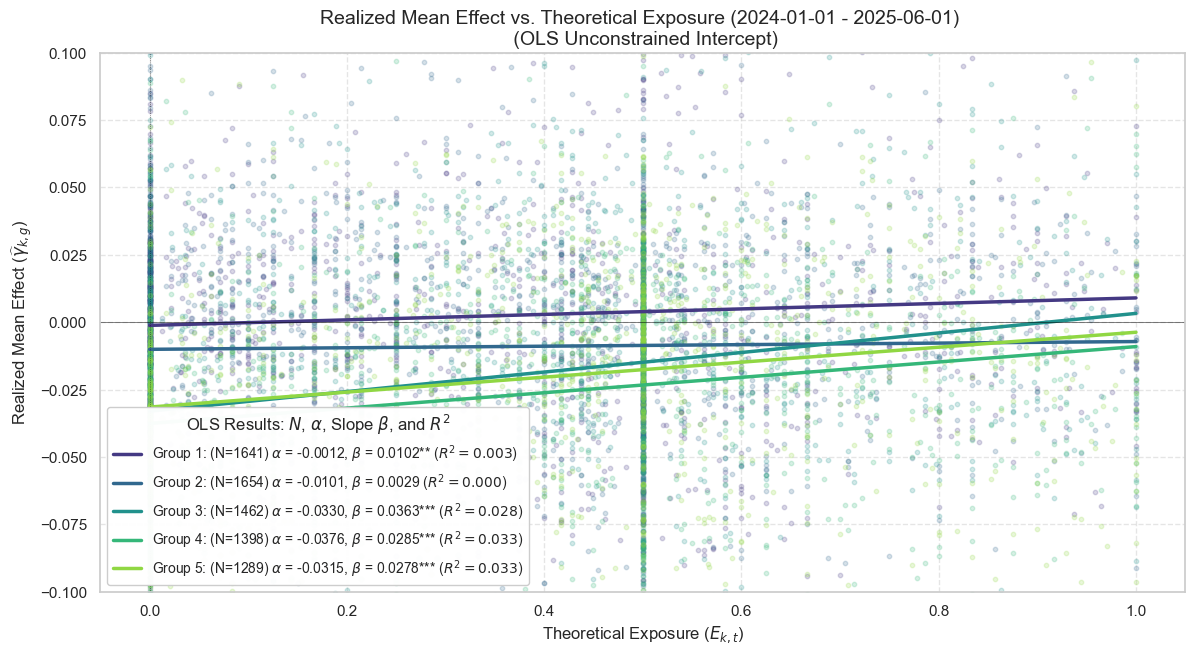

In [69]:
    
START_DATE = '2024-01-01'
END_DATE = '2025-06-01'

# Execute the main function
plot_ols_gradient(df_raw_data, START_DATE, END_DATE)

## Placebo


OLS Regression Results for: Group 1
                            OLS Regression Results                            
Dep. Variable:          beta_hat_Post   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     41.87
Date:                Mon, 08 Dec 2025   Prob (F-statistic):           1.29e-10
Time:                        16:13:01   Log-Likelihood:                 3499.2
No. Observations:                1641   AIC:                            -6994.
Df Residuals:                    1639   BIC:                            -6984.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -

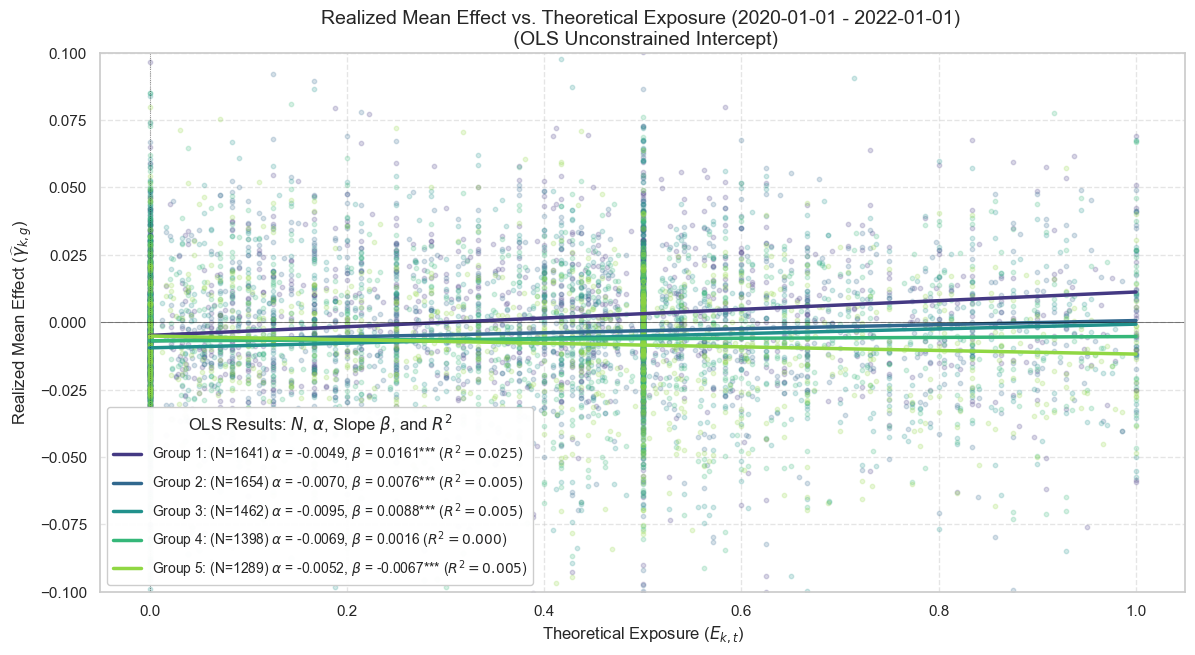

In [27]:
START_DATE = '2020-01-01'
END_DATE = '2022-01-01'

# Execute the main function
plot_ols_gradient(df_raw_data, START_DATE, END_DATE)

# Seniority

In [28]:
seniority_df = company_DWA_df.groupby(["seniority", "month"]).agg(
    effect_mean=('effect', 'mean'),
    se=('se', 'mean'))

In [29]:
seniority_df = seniority_df.reset_index()
seniority_df

,seniority,month,effect_mean,se
0,1,2021-01-01,-0.004385,0.021326
1,1,2021-02-01,-0.003720,0.020886
2,1,2021-03-01,-0.002658,0.020065
3,1,2021-04-01,-0.002503,0.019264
4,1,2021-05-01,0.004143,0.018457
...,...,...,...,...
280,5,2025-05-01,-0.023123,0.023308
281,5,2025-06-01,-0.023399,0.023684
282,5,2025-07-01,-0.023866,0.023906
283,5,2025-08-01,-0.024038,0.024235


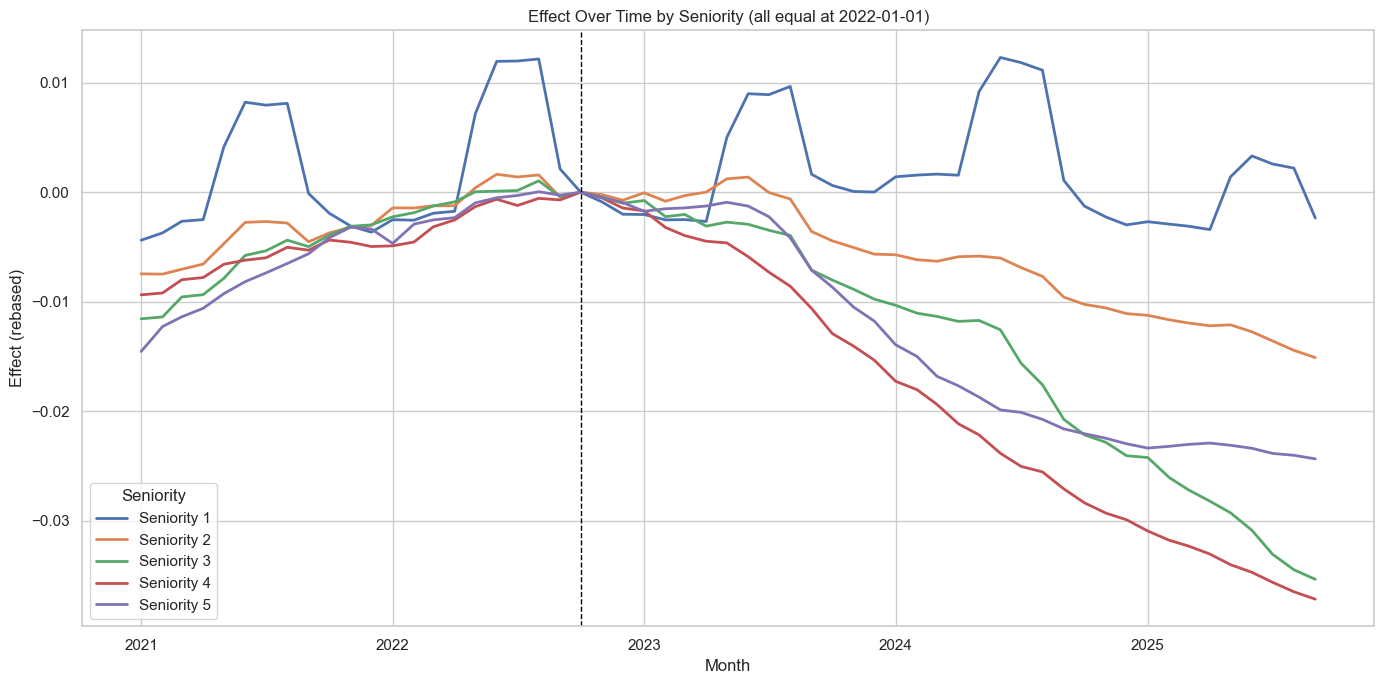

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = seniority_df.copy()
# Ensure datetime
plot_df['month'] = pd.to_datetime(plot_df['month'])

# --- STEP 1: anchor date ---
anchor_date = pd.Timestamp("2022-10-01")

# --- STEP 2: compute the shift needed for each seniority ---
anchor_vals = plot_df.loc[plot_df['month'] == anchor_date, ['seniority','effect_mean']]
shifts = anchor_vals.set_index('seniority')['effect_mean']

# --- STEP 3: apply the normalization ---
plot_df['effect_mean_adj'] = plot_df.apply(
    lambda r: r['effect_mean'] - shifts.loc[r['seniority']],
    axis=1
)

# --- STEP 4: plot without SE ---
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

for s, df_s in plot_df.groupby('seniority'):
    plt.plot(df_s['month'], df_s['effect_mean_adj'], label=f"Seniority {s}", linewidth=2)

plt.axvline(anchor_date, color='black', linestyle='--', linewidth=1)
plt.xlabel("Month")
plt.ylabel("Effect (rebased)")
plt.title("Effect Over Time by Seniority (all equal at 2022-01-01)")
plt.legend(title="Seniority")
plt.tight_layout()
plt.show()


# Exposure evolution

In [31]:
plot_df

,seniority,month,effect_mean,se,effect_mean_adj
0,1,2021-01-01,-0.004385,0.021326,-0.004385
1,1,2021-02-01,-0.003720,0.020886,-0.003720
2,1,2021-03-01,-0.002658,0.020065,-0.002658
3,1,2021-04-01,-0.002503,0.019264,-0.002503
4,1,2021-05-01,0.004143,0.018457,0.004143
...,...,...,...,...,...
280,5,2025-05-01,-0.023123,0.023308,-0.023123
281,5,2025-06-01,-0.023399,0.023684,-0.023399
282,5,2025-07-01,-0.023866,0.023906,-0.023866
283,5,2025-08-01,-0.024038,0.024235,-0.024038


/var/folders/r4/p1ptv8nj4fd5bctw6lfs_4lw0000gn/T/ipykernel_9622/2445853849.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = plot_df.groupby(['seniority', 'beta_quantile', 'month'])['effect'].mean().reset_index()
/var/folders/r4/p1ptv8nj4fd5bctw6lfs_4lw0000gn/T/ipykernel_9622/2445853849.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for quantile, df_quantile in df_seniority.groupby('beta_quantile'):


<Figure size 1400x700 with 0 Axes>

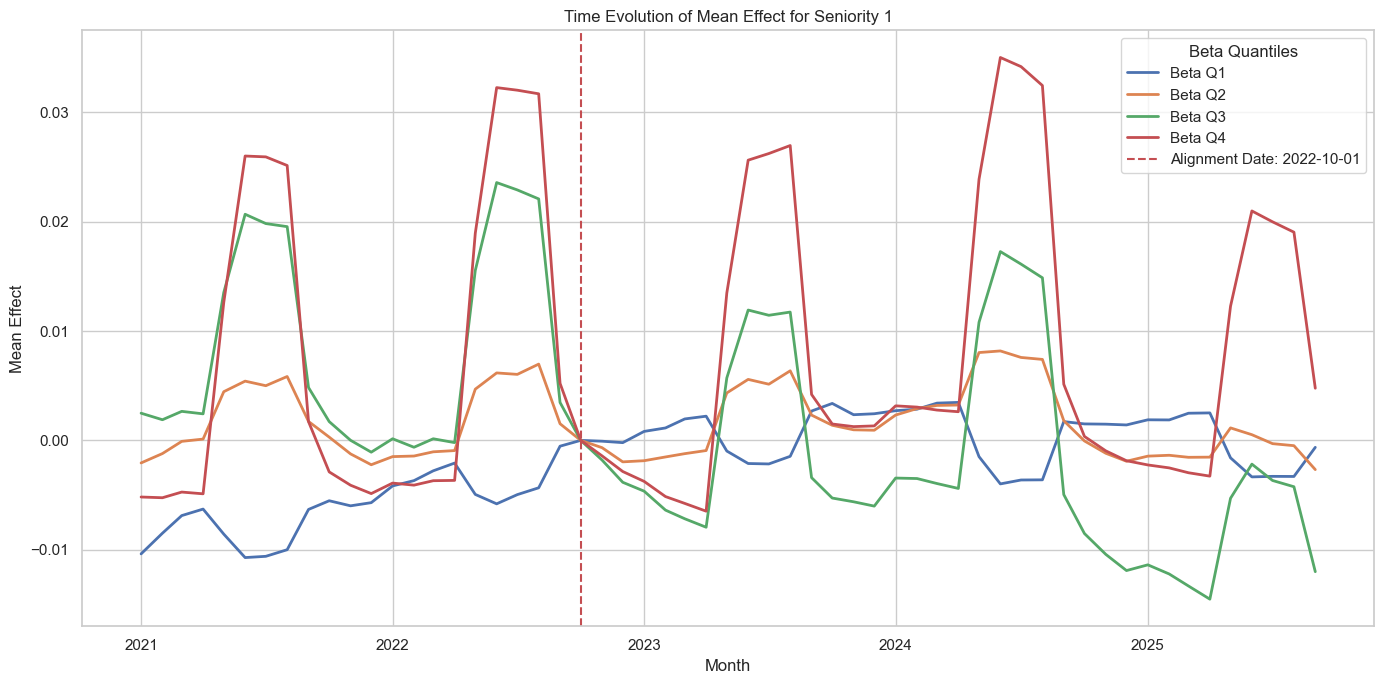

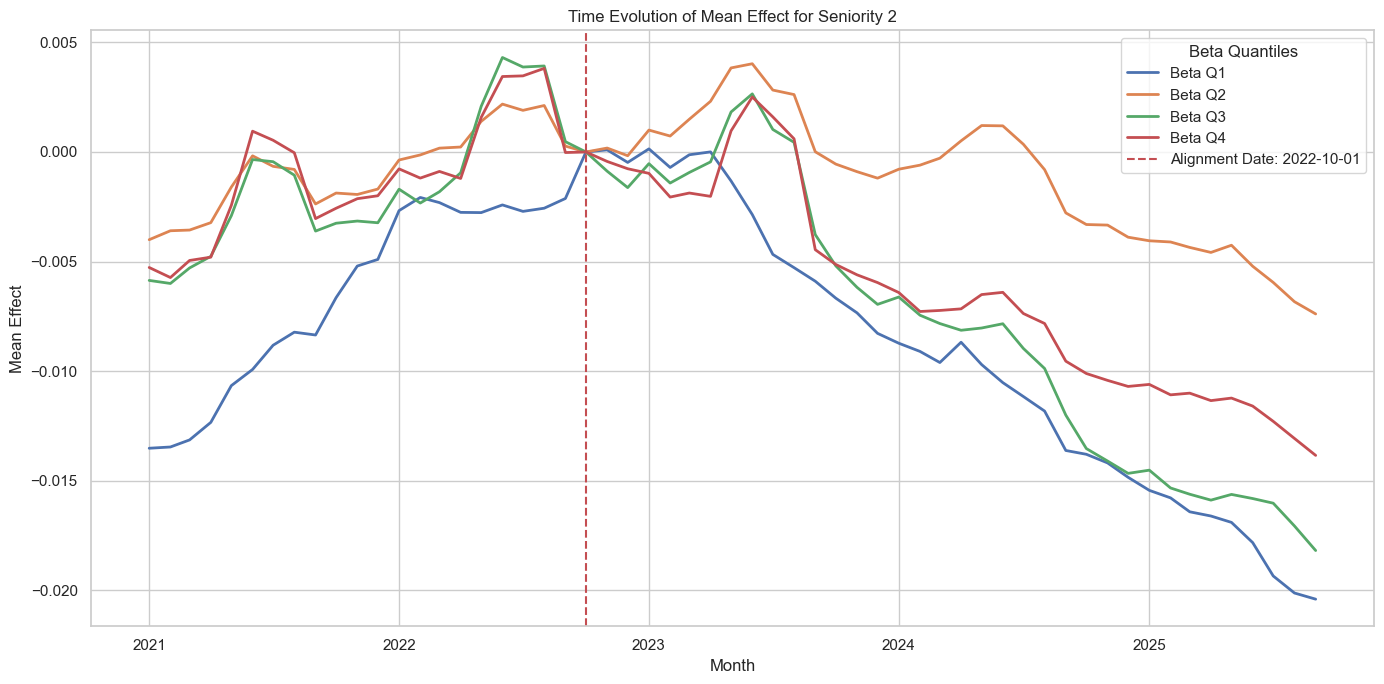

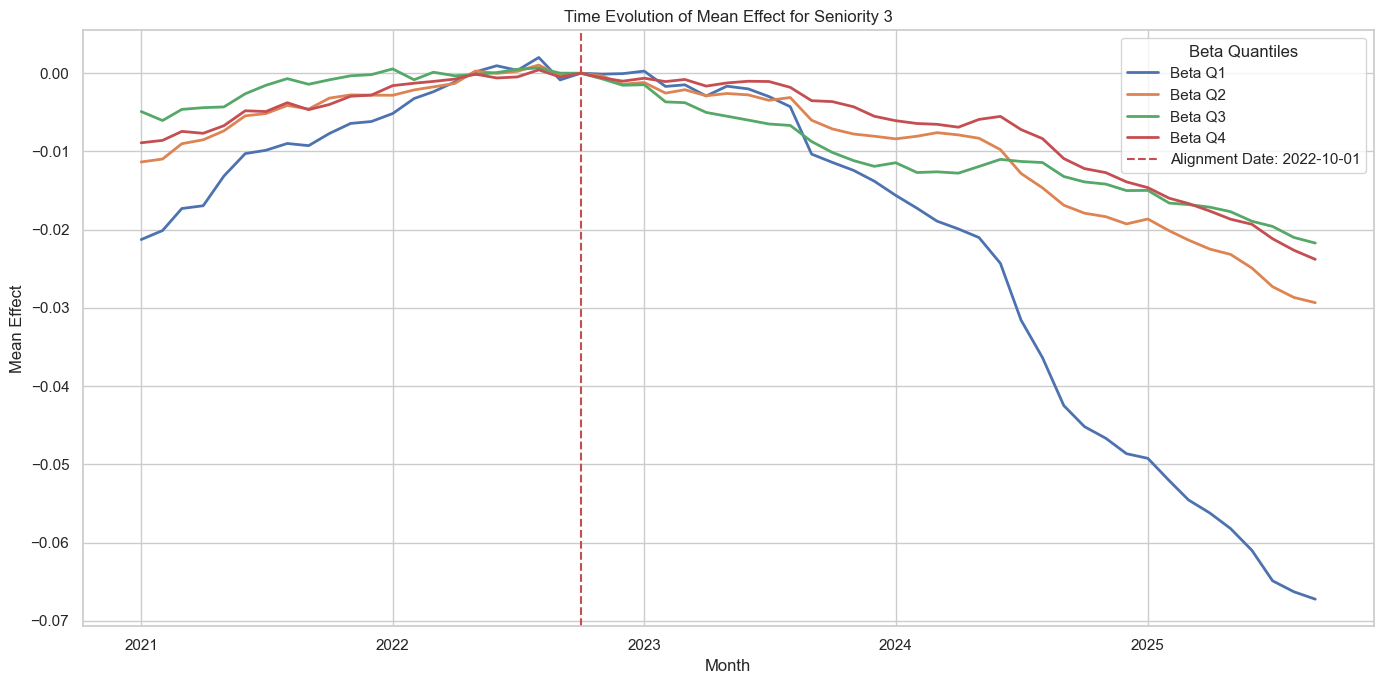

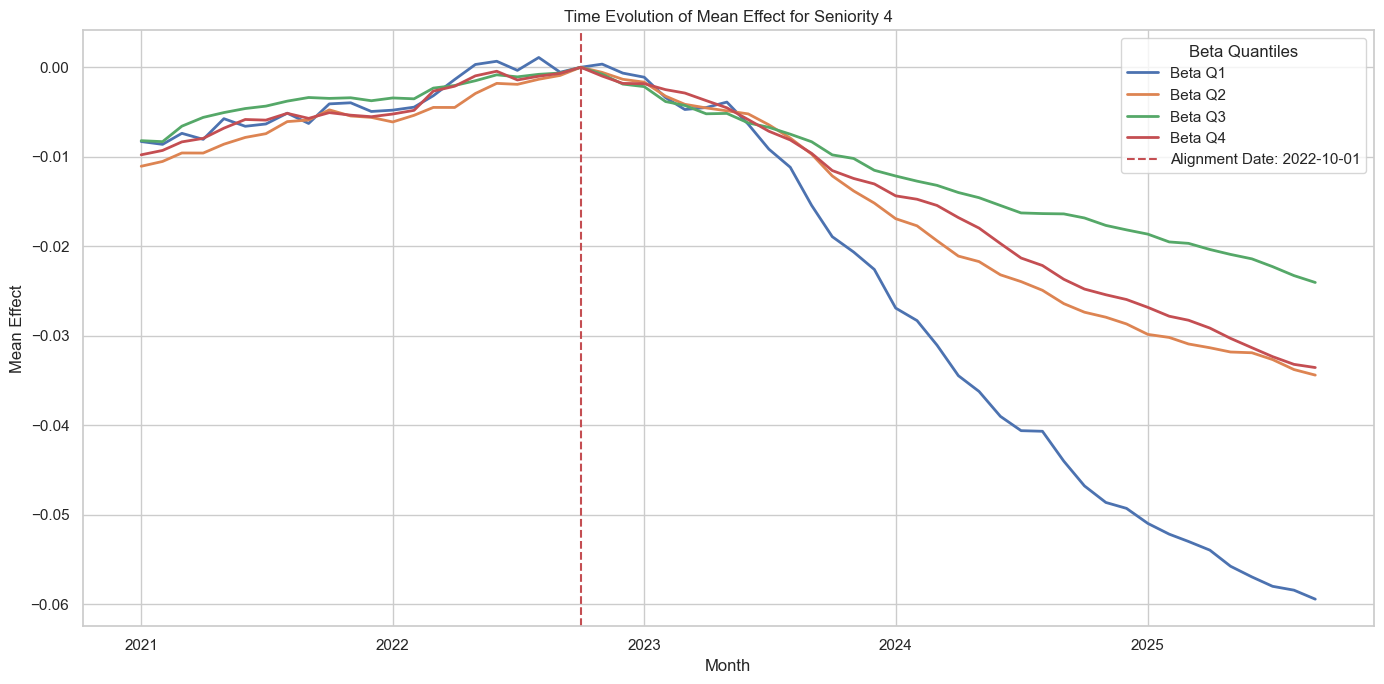

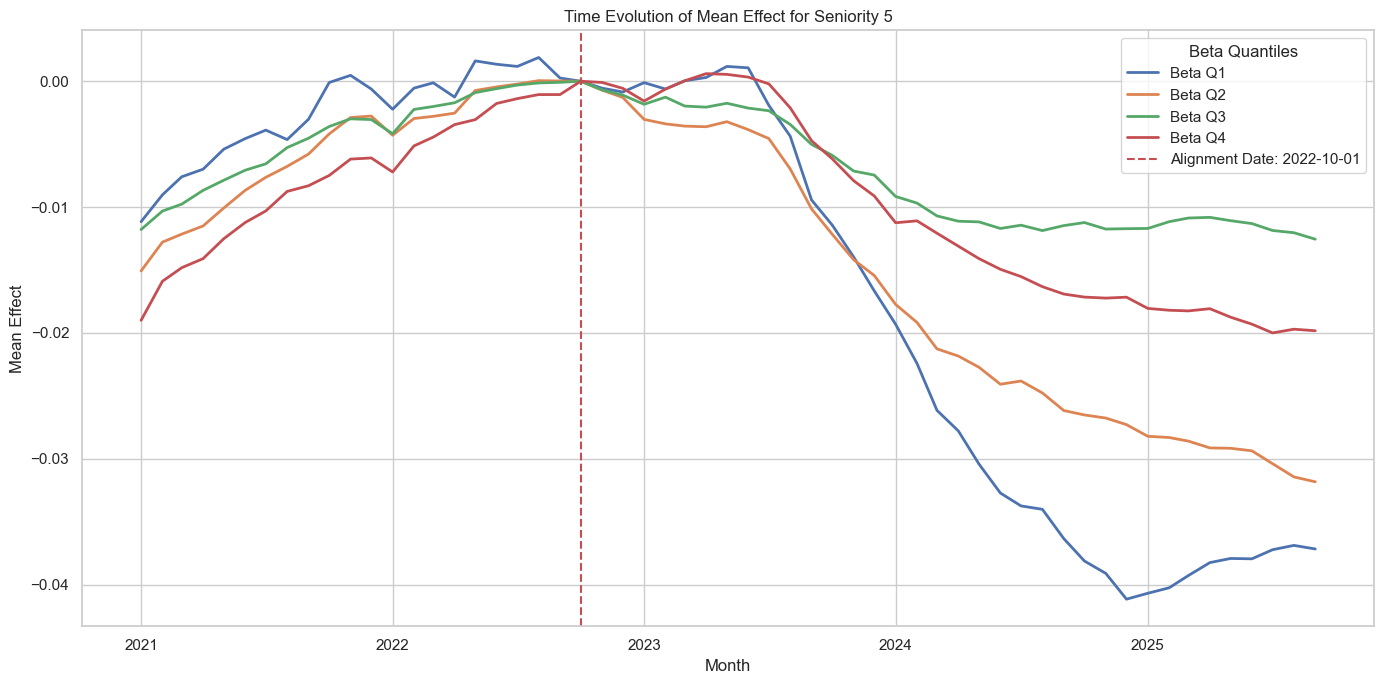

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume you already have the `plot_df` dataframe loaded.
plot_df = company_DWA_merged_df.copy()
# Ensure 'month' column is datetime
plot_df['month'] = pd.to_datetime(plot_df['month'])

# --- STEP 1: Calculate Beta Quantiles ---
# We will split the beta values into 4 quantiles (quartiles)
plot_df['beta_quantile'] = pd.qcut(plot_df['beta'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# --- STEP 2: Group by seniority and beta_quantile, then calculate mean effect ---
# We will aggregate by seniority and beta quantile to get the mean effect for each group.
grouped_df = plot_df.groupby(['seniority', 'beta_quantile', 'month'])['effect'].mean().reset_index()

# --- STEP 3: Plotting ---
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")


# Plot time evolution for each seniority and beta quantile
for seniority, df_seniority in grouped_df.groupby('seniority'):
    plt.figure(figsize=(14, 7))
    
    # Plot the time series for each beta quantile
    for quantile, df_quantile in df_seniority.groupby('beta_quantile'):
        plt.plot(df_quantile['month'], df_quantile['effect'], label=f"Beta {quantile}", linewidth=2)

    # --- ADD THE DOTTED VERTICAL LINE HERE ---
    plt.axvline(x=anchor_date, color='r', linestyle='--', linewidth=1.5, label=f'Alignment Date: {anchor_date.date()}')

    plt.title(f"Time Evolution of Mean Effect for Seniority {seniority}")
    plt.xlabel("Month")
    plt.ylabel("Mean Effect")
    plt.legend(title="Beta Quantiles")
    plt.tight_layout()
    plt.show()

In [33]:
# Get the quantile thresholds
plot_df = company_DWA_merged_df.copy()
plot_df['month'] = pd.to_datetime(plot_df['month'])

# Get quantile thresholds (bins)
_, bins = pd.qcut(plot_df['beta'], 4, retbins=True, duplicates='drop')

print("Quantile thresholds:")
for i in range(len(bins)-1):
    print(f"Q{i+1}: {bins[i]} to {bins[i+1]}")


Quantile thresholds:
Q1: 0.0 to 0.07142857142857142
Q2: 0.07142857142857142 to 0.4
Q3: 0.4 to 0.5192307692307693
Q4: 0.5192307692307693 to 1.0


<>:137: SyntaxWarning: invalid escape sequence '\l'
<>:137: SyntaxWarning: invalid escape sequence '\l'
/var/folders/r4/p1ptv8nj4fd5bctw6lfs_4lw0000gn/T/ipykernel_9622/511617515.py:137: SyntaxWarning: invalid escape sequence '\l'
  plt.title(f'Gradient Test: Estimated $\lambda_g$ by Seniority\n(Control Method: {title_method})')


--- 1. Preparing AI Exposure Data ---
Prepared 2083 unique DWA exposure scores (using 'beta').
--- 2. Loading and Aggregating Regression Results (_method_company_seniority) ---
Aggregation complete. Rows for Gradient Test: 7,444
--- 3. Running Gradient Test (WLS) ---
  -> Testing Seniority Level: 1
  -> Testing Seniority Level: 2
  -> Testing Seniority Level: 3
  -> Testing Seniority Level: 4
  -> Testing Seniority Level: 5

✅ Gradient Test Summary Saved to CSV: ./results/gradient_test_summary_method_company_seniority.csv
--- 4. Generating Average Task Demand Plot (Event Study) ---

✅ Event Study Plot (Full Time Series) saved to: ./results/event_study_avg_seniority_method_company_seniority_full_ts.png
--- 5. Generating Heterogeneity Event Study Plot (5 Quantiles) ---


/var/folders/r4/p1ptv8nj4fd5bctw6lfs_4lw0000gn/T/ipykernel_9622/511617515.py:309: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_subset = subset.groupby(['month', 'exposure_bin']).agg(
/var/folders/r4/p1ptv8nj4fd5bctw6lfs_4lw0000gn/T/ipykernel_9622/511617515.py:309: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_subset = subset.groupby(['month', 'exposure_bin']).agg(
/var/folders/r4/p1ptv8nj4fd5bctw6lfs_4lw0000gn/T/ipykernel_9622/511617515.py:309: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

✅ Heterogeneity Plot (5 bins) saved to: ./results/heterogeneity_paths_5q_method_company_seniority.png


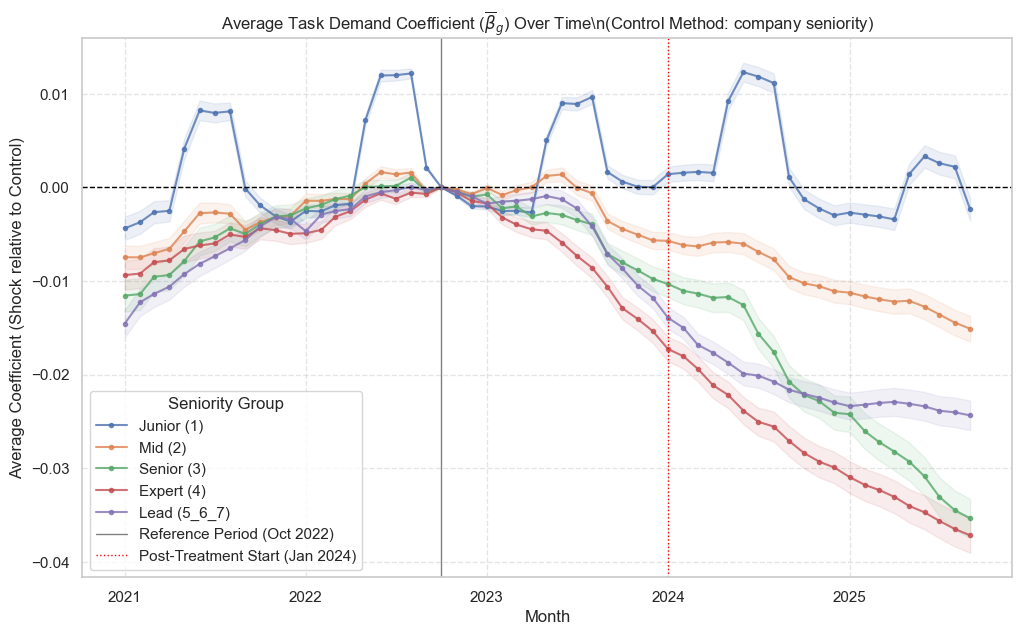

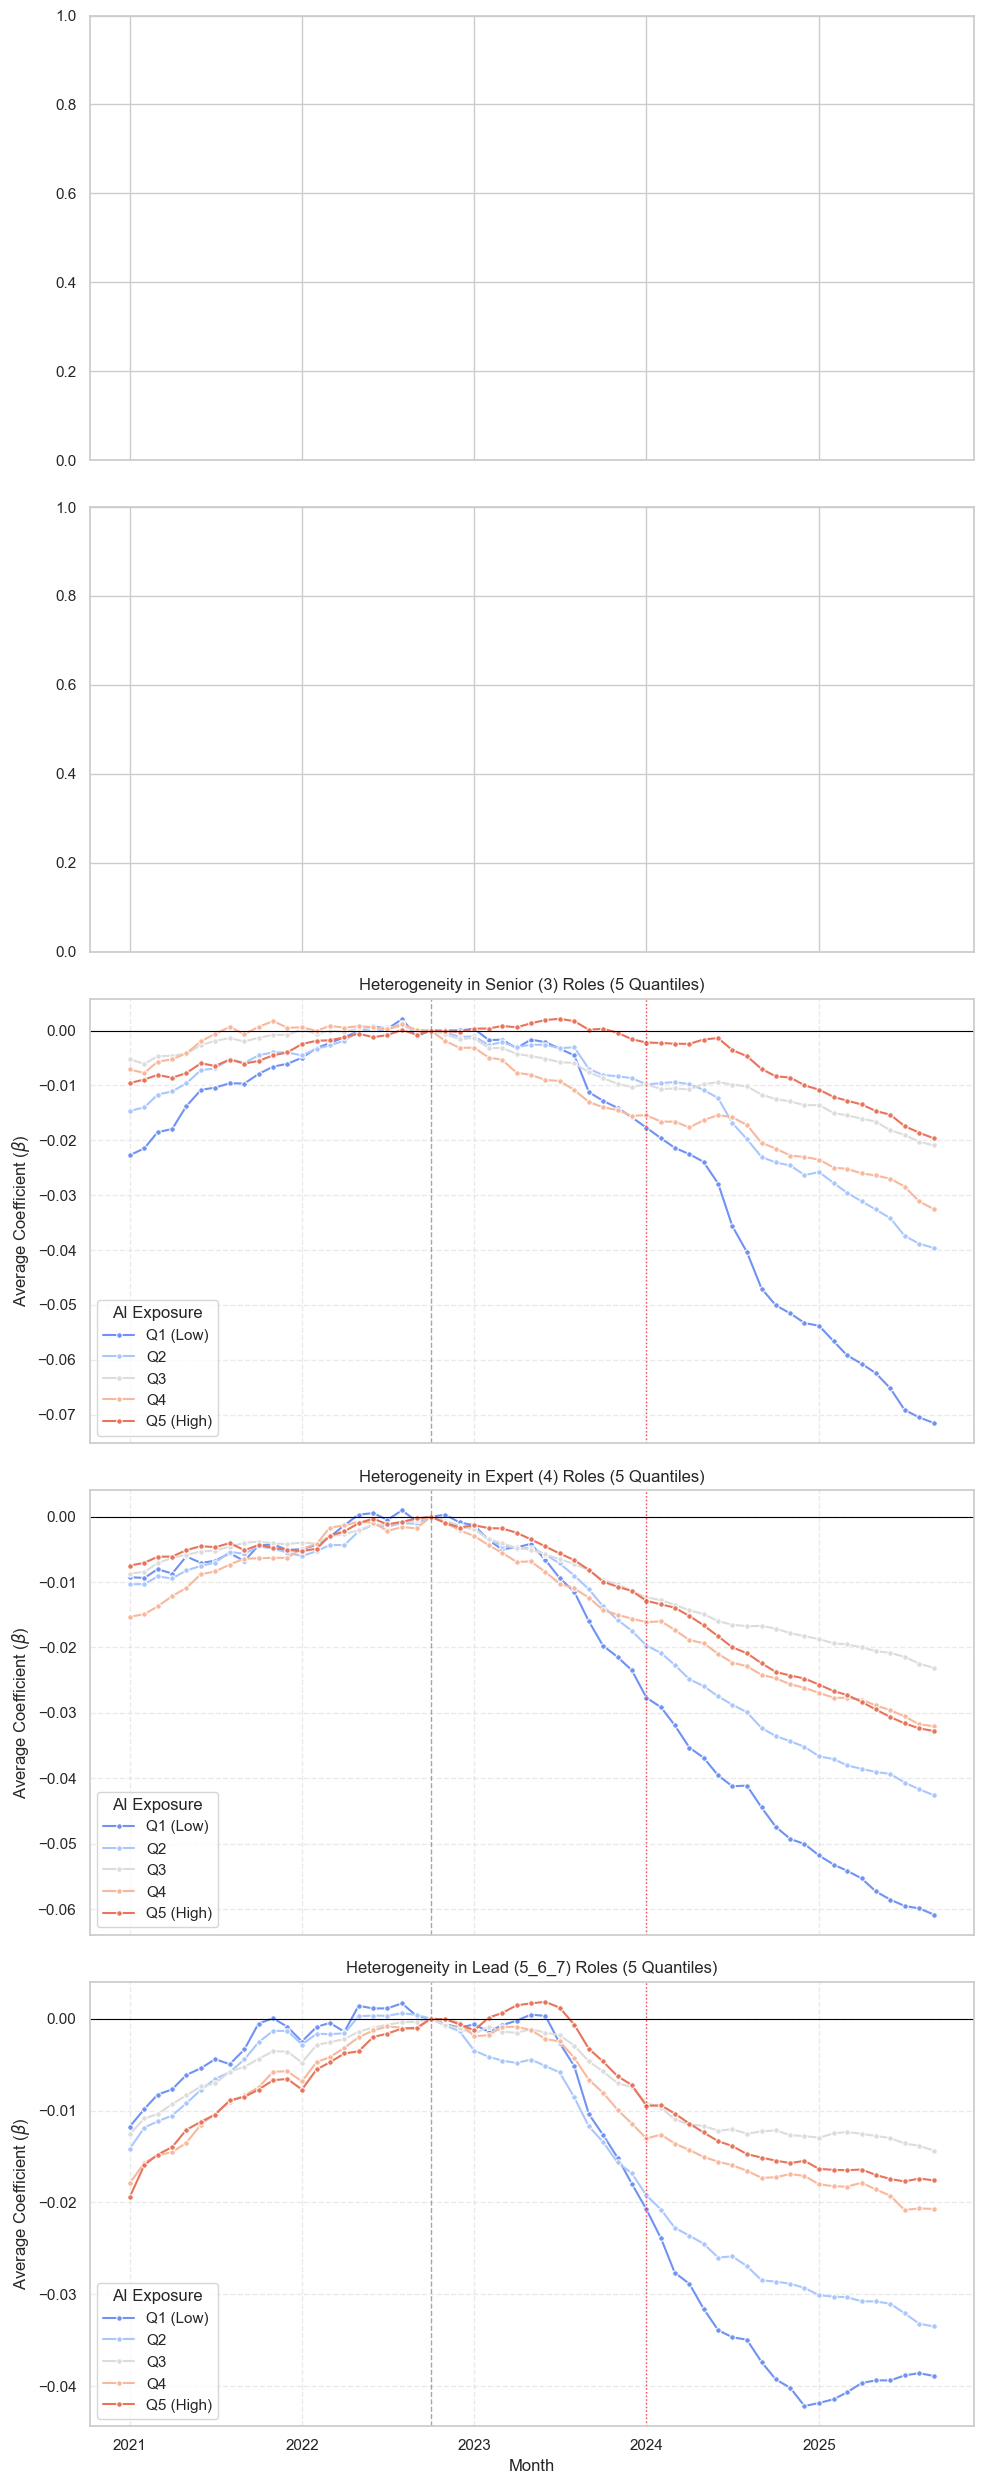

In [109]:
import pandas as pd
import numpy as np
import os
import glob
from statsmodels.regression.linear_model import WLS
import matplotlib.pyplot as plt
import seaborn as sns
from enum import IntEnum

# --- CONFIGURATION (START) ---
class ControlMethod(IntEnum):
    COMPANY_WIDE = 1
    COMPANY_SENIORITY = 2

# **Configuration set to COMPANY_SENIORITY based on your last provided context.**
CONTROL_METHOD = ControlMethod.COMPANY_SENIORITY
EXPOSURE_METRIC = 'beta'  # Options: 'alpha', 'beta', 'gamma'

# --- GLOBAL DATES AND PATHS --
REF_PERIOD = '2022-10-01'
POST_START = '2024-01-01'
POST_END = '2025-09-01'
RESULTS_DIR = "./results" 
METHOD_SUFFIX = "_method_company" if CONTROL_METHOD == ControlMethod.COMPANY_WIDE else "_method_company_seniority"
OUTPUT_SUMMARY_FILE = os.path.join(RESULTS_DIR, f"gradient_test_summary{METHOD_SUFFIX}.csv")
# ----------------------------

# =========================================================================
# 1. DATA PREPARATION FUNCTIONS
# =========================================================================

def prepare_exposure_data():
    """
    Loads task-level exposure, maps it to DWAs, and calculates the mean DWA exposure score.
    Returns the E_Theory map (using '{EXPOSURE_METRIC}').
    """
    print("--- 1. Preparing AI Exposure Data ---")
    
    # Load and clean exposure data (Assumed to be in './data/')
    exposure_df = pd.read_csv("./data/full_labelset.tsv", sep="\t")
    exposure_df = exposure_df[["Task ID", "alpha", "beta", "gamma"]]
    
    # Load and clean task-to-DWA map
    task_dwa_map = pd.read_csv('./data/Tasks to DWAs.csv')
    task_dwa_map = task_dwa_map[["DWA ID", "Task ID"]]
    
    # Merge, group, and calculate mean DWA exposure
    DWA_exposure_df = pd.merge(exposure_df, task_dwa_map, on="Task ID", how ="inner")
    
    DWA_exposure_df = DWA_exposure_df.groupby('DWA ID').agg(
        beta=(EXPOSURE_METRIC, 'mean')
    ).reset_index()
    
    # Create the E_Theory map using the 'beta' column
    E_Theory_map = DWA_exposure_df.set_index('DWA ID')[EXPOSURE_METRIC].to_dict()
    
    print(f"Prepared {len(E_Theory_map)} unique DWA exposure scores (using '{EXPOSURE_METRIC}').")
    return E_Theory_map


def load_and_aggregate_results(results_dir, method_suffix, post_start, post_end):
    """
    Loads all Stage 1 regression results, calculates the cumulative post-treatment shock 
    (gamma_k,g^Post), and the WLS weights. Returns the full results for plotting and the aggregated results.
    """
    print(f"--- 2. Loading and Aggregating Regression Results ({method_suffix}) ---")
    
    search_pattern = os.path.join(results_dir, f"regression_results_seniority_*{method_suffix}.parquet")
    all_files = glob.glob(search_pattern)
    
    if not all_files:
        print(f"ERROR: No regression files found matching pattern: {search_pattern}.")
        print("Please run the Stage 1 regression code (2_regression.ipynb) first.")
        return None, None
        
    all_results = pd.concat([pd.read_parquet(f) for f in all_files], ignore_index=True)
    all_results['month'] = pd.to_datetime(all_results['month'])

    # Filter to the post-treatment period for aggregation
    df_post = all_results[
        (all_results['month'] >= post_start) & (all_results['month'] <= post_end)
    ].copy()

    # Calculate average shock (gamma_post)
    gamma_sum = df_post.groupby(['dwa_id', 'seniority'])[EXPOSURE_METRIC].sum().reset_index(name=f'{EXPOSURE_METRIC}_sum')
    month_counts = df_post.groupby(['dwa_id', 'seniority'])['month'].nunique().reset_index(name='T_post')
    df_gamma = pd.merge(gamma_sum, month_counts, on=['dwa_id', 'seniority'])
    df_gamma['gamma_post'] = df_gamma[f'{EXPOSURE_METRIC}_sum'] / df_gamma['T_post'] 

    # Calculate WLS weights (inverse variance)
    df_post['se_squared'] = df_post['se']**2
    # Aggregation creates a column named 'sum_var_beta'
    sum_var_beta = df_post.groupby(['dwa_id', 'seniority'])['se_squared'].sum().reset_index(name='sum_var_beta')
    df_gamma = pd.merge(df_gamma, sum_var_beta, on=['dwa_id', 'seniority'])
    
    # --- FIX APPLIED HERE: Corrected mismatched column name from 'sum_se_squared' to 'sum_var_beta' ---
    df_gamma['var_gamma_post'] = df_gamma['sum_var_beta'] / (df_gamma['T_post']**2)
    df_gamma['wls_weight'] = 1 / df_gamma['var_gamma_post'].clip(lower=1e-8) 
    
    print(f"Aggregation complete. Rows for Gradient Test: {len(df_gamma):,}")
    
    # Drop intermediate columns
    cols_to_drop = ['beta_sum', 'T_post', 'sum_var_beta'] 
    return all_results, df_gamma.drop(columns=cols_to_drop)


# =========================================================================
# 3. WLS REGRESSION AND PLOTTING FUNCTIONS
# =========================================================================

def plot_lambda_results(df_summary, method_suffix):
    """Plots the estimated lambda_g coefficients (Gradient Test plot)."""
    plt.figure(figsize=(10, 6))
    
    df_summary['ci_lower'] = df_summary['lambda_g'] - 1.96 * df_summary['se_lambda_g']
    df_summary['ci_upper'] = df_summary['lambda_g'] + 1.96 * df_summary['se_lambda_g']

    seniority_map = {1: 'Junior (1)', 2: 'Mid (2)', 3: 'Senior (3)', 4: 'Expert (4)', 5: 'Lead (5_6_7)'}
    df_summary['seniority_label'] = df_summary['seniority_level'].astype(str).map(seniority_map)
    
    # Ensure correct plotting order
    sort_order = [1, 2, 3, 4, 5] 
    sorted_levels = [s for s in sort_order if s in df_summary['seniority_level'].tolist()]
    df_summary = df_summary.set_index('seniority_level').loc[sorted_levels].reset_index()

    plt.errorbar(
        df_summary['seniority_label'], 
        df_summary['lambda_g'], 
        yerr=[df_summary['lambda_g'] - df_summary['ci_lower'], df_summary['ci_upper'] - df_summary['lambda_g']],
        fmt='o', 
        capsize=5, 
        label=r'$\lambda_g$ Estimate (95% CI)'
    )
    
    plt.axhline(0, color='red', linestyle='--', linewidth=0.8)
    title_method = method_suffix.strip("_method_").replace('_', ' ')
    plt.title(f'Gradient Test: Estimated $\lambda_g$ by Seniority\n(Control Method: {title_method})')
    plt.xlabel('Seniority Group')
    plt.ylabel(r'Marginal Impact of AI Exposure ($\lambda_g$)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    
    plot_filename = os.path.join(RESULTS_DIR, f"gradient_test_plot{method_suffix}.png")
    plt.savefig(plot_filename)
    print(f"\n✅ Final Gradient Plot saved to: {plot_filename}")


def run_gradient_test(df_gamma, E_Theory_map, output_file, method_suffix):
    """
    Performs the WLS regression for the cross-sectional validation (Gradient Test) 
    and outputs the summary table and the plot.
    """
    print("--- 3. Running Gradient Test (WLS) ---")
    
    df_gamma['E_Theory'] = df_gamma['dwa_id'].map(E_Theory_map)
    df_gamma.dropna(subset=['E_Theory'], inplace=True)
    
    seniority_groups = df_gamma['seniority'].unique()
    results_summary = []

    for seniority_level in sorted(seniority_groups):
        print(f"  -> Testing Seniority Level: {seniority_level}")
        df_group = df_gamma[df_gamma['seniority'] == seniority_level].copy()
        
        Y = df_group['gamma_post'] 
        X = df_group['E_Theory']
        W = df_group['wls_weight'] 
        
        X_w_const = pd.concat([X, pd.Series(1, index=X.index, name='const')], axis=1)

        if len(df_group) < 2:
            continue
            
        try:
            model = WLS(endog=Y, exog=X_w_const, weights=W).fit(cov_type='HC0')
            
            results_summary.append({
                'seniority_level': seniority_level,
                'N_tasks': len(df_group),
                'lambda_g': model.params['E_Theory'],
                'se_lambda_g': model.bse['E_Theory'],
                't_stat_lambda_g': model.tvalues['E_Theory'],
                'p_value_lambda_g': model.pvalues['E_Theory'],
                'R_squared': model.rsquared
            })

        except Exception as e:
            print(f"   (WARNING: WLS failed for seniority {seniority_level}: {e})")
            
    df_summary = pd.DataFrame(results_summary)
    
    if not df_summary.empty:
        df_summary.to_csv(output_file, index=False)
        print("\n" + "="*50)
        print(f"✅ Gradient Test Summary Saved to CSV: {output_file}")
        print("="*50)
        #plot_lambda_results(df_summary, method_suffix) 
        
    return df_summary

def plot_average_task_demand(all_results, results_dir, method_suffix, ref_period):
    """
    Filters the full regression results to the reference period onwards and plots the average beta over time.
    """
    print(f"--- 4. Generating Average Task Demand Plot (Event Study) ---")

    # 1. Aggregation and Variance Calculation
    avg_df = all_results.groupby(['month', 'seniority']).agg(
        avg_beta=(f"{EXPOSURE_METRIC}", 'mean'),
        N_dwas=('dwa_id', 'nunique'),
        sum_se_squared=('se', lambda x: (x**2).sum())
    ).reset_index()

    avg_df['var_avg_beta'] = avg_df['sum_se_squared'] / avg_df['N_dwas']**2
    avg_df['se_avg_beta'] = np.sqrt(avg_df['var_avg_beta'])

    # 95% Confidence Intervals
    avg_df['ci_lower'] = avg_df['avg_beta'] - 1.96 * avg_df['se_avg_beta']
    avg_df['ci_upper'] = avg_df['avg_beta'] + 1.96 * avg_df['se_avg_beta']

    # --- FILTER REMOVED HERE ---
    # The original line: avg_df = avg_df[avg_df['month'] >= REF_DT].copy() is removed.
    # The dataframe 'avg_df' now contains all available months.

    # 2. Plotting
    plt.figure(figsize=(12, 7))
    seniority_map = {1: 'Junior (1)', 2: 'Mid (2)', 3: 'Senior (3)', 4: 'Expert (4)', 5: 'Lead (5_6_7)'}

    for level, group in avg_df.groupby('seniority'):
        label = seniority_map.get(level, f'Level {level}')

        plt.plot(group['month'], group['avg_beta'], marker='.', linestyle='-', label=label, alpha=0.8)

        plt.fill_between(
            group['month'],
            group['ci_lower'],
            group['ci_upper'],
            alpha=0.1,
            color=plt.gca().lines[-1].get_color()
        )

    plt.axhline(0, color='black', linestyle='--', linewidth=1)

    # Note: These vertical lines are kept as they are critical markers for the analysis.
    plt.axvline(pd.to_datetime(ref_period), color='gray', linestyle='-', linewidth=1, label='Reference Period (Oct 2022)')
    plt.axvline(pd.to_datetime(POST_START), color='red', linestyle=':', linewidth=1, label='Post-Treatment Start (Jan 2024)')

    title_method = method_suffix.strip("_method_").replace('_', ' ')
    plt.title(rf'Average Task Demand Coefficient ($\overline{{\{EXPOSURE_METRIC}}}_g$) Over Time\n(Control Method: {title_method})')
    plt.xlabel('Month')
    plt.ylabel(r'Average Coefficient (Shock relative to Control)')
    plt.legend(title='Seniority Group', loc='lower left')
    plt.grid(True, linestyle='--', alpha=0.5)

    # Changed filename to reflect the full time series
    plot_filename = os.path.join(RESULTS_DIR, f"event_study_avg_seniority{method_suffix}_full_ts.png")
    plt.savefig(plot_filename)
    print(f"\n✅ Event Study Plot (Full Time Series) saved to: {plot_filename}")

def plot_heterogeneity_event_study(all_results, E_Theory_map, results_dir, method_suffix, ref_period, n_bins=4):
    """
    Splits tasks into `n_bins` quantiles within each seniority group and plots 
    separate event-study paths to visualize heterogeneity/repositioning effects.
    
    Args:
        n_bins (int): Number of quantiles to split exposure into (e.g., 3=terciles, 4=quartiles).
    """
    print(f"--- 5. Generating Heterogeneity Event Study Plot ({n_bins} Quantiles) ---")

    # 1. Prepare Exposure Dataframe
    exposure_df = pd.DataFrame(list(E_Theory_map.items()), columns=['dwa_id', 'exposure_score'])

    # 2. Merge time-series results with exposure scores
    merged_df = pd.merge(all_results, exposure_df, on='dwa_id', how='inner')

    # 3. Define Seniority Map
    seniority_map = {1: 'Junior (1)', 2: 'Mid (2)', 3: 'Senior (3)', 4: 'Expert (4)', 5: 'Lead (5_6_7)'}
    unique_levels = sorted(merged_df['seniority'].unique())
    
    # 4. Setup Plot Grid
    n_levels = len(unique_levels)
    fig, axes = plt.subplots(n_levels, 1, figsize=(10, 5 * n_levels), sharex=True)
    if n_levels == 1: axes = [axes] 

    # 5. Generate Dynamic Palette (Cool to Warm: Blue -> Red)
    # n_bins=4 will give 4 distinct colors, n_bins=5 will give 5, etc.
    palette_colors = sns.color_palette("coolwarm", n_bins)
    
    # Generate Labels based on n_bins (e.g., Q1 (Low), Q2, Q3, Q4 (High))
    labels = [f"Q{i+1}" for i in range(n_bins)]
    labels[0] += " (Low)"
    labels[-1] += " (High)"

    # 6. Loop through Seniority Levels
    for ax, level in zip(axes, unique_levels):
        subset = merged_df[merged_df['seniority'] == level].copy()

        try:
            subset['exposure_bin'] = pd.qcut(
                subset['exposure_score'], 
                n_bins, 
                labels=labels
            )
        except ValueError:
            print(f"Warning: Insufficient unique exposure values for Seniority {level} to calculate {n_bins} quantiles.")
            continue

        # Aggregate Mean Beta by Month and Bin
        agg_subset = subset.groupby(['month', 'exposure_bin']).agg(
            mean_beta=('beta', 'mean')
        ).reset_index()

        # Plotting
        sns.lineplot(
            data=agg_subset, 
            x='month', 
            y='mean_beta', 
            hue='exposure_bin',
            palette=palette_colors,
            ax=ax, 
            marker='o', 
            markersize=4,
            linewidth=1.5
        )

        # Formatting
        level_label = seniority_map.get(level, f'Level {level}')
        ax.set_title(f"Heterogeneity in {level_label} Roles ({n_bins} Quantiles)")
        ax.axhline(0, color='black', linestyle='-', linewidth=0.8)
        
        # Vertical Reference Lines
        ax.axvline(pd.to_datetime(ref_period), color='gray', linestyle='--', linewidth=1, alpha=0.7)
        ax.axvline(pd.to_datetime(POST_START), color='red', linestyle=':', linewidth=1, alpha=0.7)
        
        ax.set_ylabel(r'Average Coefficient ($\beta$)')
        ax.legend(title="AI Exposure", loc='lower left')
        ax.grid(True, linestyle='--', alpha=0.4)

    plt.xlabel('Month')
    plt.tight_layout()
    
    plot_filename = os.path.join(results_dir, f"heterogeneity_paths_{n_bins}q{method_suffix}.png")
    plt.savefig(plot_filename)
    print(f"✅ Heterogeneity Plot ({n_bins} bins) saved to: {plot_filename}")
# =========================================================================
# 5. MAIN EXECUTION
# =========================================================================
# =========================================================================
# 5. MAIN EXECUTION
# =========================================================================

if __name__ == "__main__":
    
    # 1. Prepare E_Theory data
    E_Theory_map = prepare_exposure_data()
    
    # 2. Load and aggregate regression results 
    # (returns 'all_results' for plotting and 'df_gamma_post' for WLS)
    all_results, df_gamma_post = load_and_aggregate_results(RESULTS_DIR, METHOD_SUFFIX, POST_START, POST_END)
    
    if df_gamma_post is not None:
        # 3. Run the WLS Gradient Test (Equation 27) and plot lambda_g
        run_gradient_test(df_gamma_post, E_Theory_map, OUTPUT_SUMMARY_FILE, METHOD_SUFFIX)
        
        # 4. Generate the Average Task Demand Plot (Event Study - Aggregate)
        plot_average_task_demand(all_results, RESULTS_DIR, METHOD_SUFFIX, REF_PERIOD)

        # 5. Generate Heterogeneity Plot (Event Study - Split by Exposure)
        plot_heterogeneity_event_study(all_results, E_Theory_map, RESULTS_DIR, METHOD_SUFFIX, REF_PERIOD, n_bins=5)